# Toy LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


### Toy Data

In [4]:
n_steps = 24 * 3
n_ahead = 12

n_series = 5000

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [5]:
s = generate_time_series(n_series, n_steps+n_ahead)

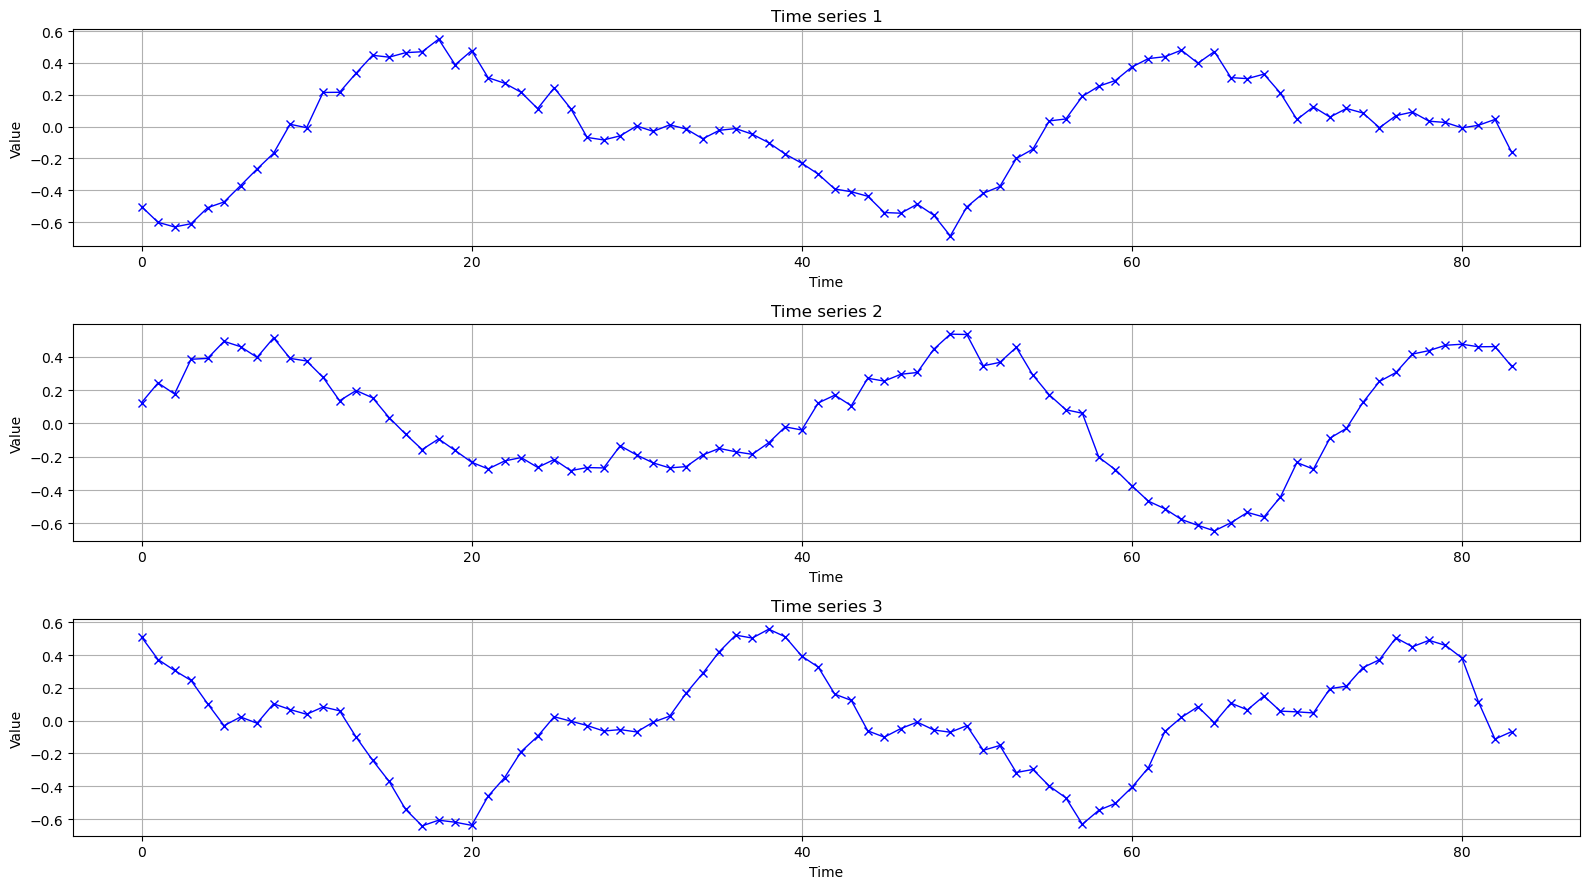

In [6]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Train-Test split

cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (4000, 72)
y_train shape: (4000, 12)
X_valid shape: (1000, 72)
y_valid shape: (1000, 12)


In [8]:
# form datasets, dataloaders, etc

BATCH_SIZE = 512

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# Early stopping class to prevent overfitting

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we accept with validation loss non decreasing
        self.patience = patience
        # tolerance for non decrease
        self.min_delta = min_delta
        # how many epochs without validation loss decrease
        self.counter = 0
        # minimum validation loss to beat
        self.min_validation_loss = float('inf')
        self.status = False

    def early_stop(self, validation_loss):
        # is the last validation loss better than the current minimum ?
        # status = True means stop training
        if validation_loss < self.min_validation_loss:
            # yes : update minimum value and reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.status = False
            # no : are we within tolerance ?
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # no : increase counter (losing patience)
            self.counter += 1
            # have we lost patience ?
            if self.counter >= self.patience:
                # yes
                self.status = True
            else:
                # no
                self.status = False

        return self.status, self.counter
    
early_stopping = EarlyStoppingCallback(patience=10, min_delta=1e-2)

# Toy 1 : RNN

In [10]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [11]:
hidden_dim = 64
num_layers = 4

In [12]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)


In [13]:
def train_loop(model, train_loader, test_loader, criterion, optimizer, num_epochs, early_stopping=None, PATH_TO_SAVE='best_model.pth', display_frequency=10):
    
    train_losses = []
    valid_losses = []
    best_val_loss = float('inf')

    for i in range(num_epochs):
        # loop on training data
        model.train()
        optimizer.zero_grad()
        ### loop on training data
        train_epoch_loss = 0
        for input, target in train_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            # print(f"input has shape {input.shape}")
            target = target.to(device).view(-1, n_ahead, 1)
            # print(f"target has shape {target.shape}")
            output = model(input)
            if output.ndim == 2 and target.ndim == 3:
                output = output.view(-1, n_ahead, 1)
            # print(F"output has shape {output.shape}")
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader) 
        train_losses.append(train_epoch_loss)
        
        # test step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for input, target in test_loader:
                input = input.to(device).unsqueeze(-1)  # add a feature dimension
                target = target.to(device).view(-1, n_ahead, 1)
                output = model(input)
                if output.ndim == 2 and target.ndim == 3:
                    output = output.view(-1, n_ahead, 1)
                loss = criterion(output, target)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(test_loader)
        valid_losses.append(val_epoch_loss)
        
        # Save the best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), PATH_TO_SAVE)
            msg = f' - Saving model at epoch {i+1} with validation loss {val_epoch_loss:.4e}'
        else:
            msg = ''
        
        # early stopping check
        if early_stopping:
            stop, counter = early_stopping.early_stop(val_epoch_loss)
            if stop:
                print(f'Early stopping at epoch {i+1} with counter {counter}')
                break
        
        # report out
        if (i+1) % display_frequency == 0:
            msg = f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}" + msg
            print(msg)
            
    trained_model = torch.load(PATH_TO_SAVE)
            
    return train_losses, valid_losses, trained_model

In [14]:
criterion = nn.MSELoss()
lr = 1e-5
num_epochs = 1000
patience = 10
min_delta = 1e-3

early_stopping = EarlyStoppingCallback(patience=patience, min_delta=min_delta)

In [15]:
model = rnn 
PATH_TO_SAVE = 'best_rnn_model.pth'
print(f"Start training RNN model for {num_epochs} epochs")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training RNN model for 1000 epochs


In [16]:
train_losses, valid_losses, trained_model = train_loop(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    early_stopping=early_stopping,
    PATH_TO_SAVE=PATH_TO_SAVE,
    display_frequency=1
)

epoch    1/1000, training loss = 1.0992e-01, validation loss = 1.1125e-01 - Saving model at epoch 1 with validation loss 1.1125e-01
epoch    2/1000, training loss = 1.0923e-01, validation loss = 1.1060e-01 - Saving model at epoch 2 with validation loss 1.1060e-01
epoch    3/1000, training loss = 1.0853e-01, validation loss = 1.0995e-01 - Saving model at epoch 3 with validation loss 1.0995e-01
epoch    4/1000, training loss = 1.0806e-01, validation loss = 1.0940e-01 - Saving model at epoch 4 with validation loss 1.0940e-01
epoch    5/1000, training loss = 1.0733e-01, validation loss = 1.0873e-01 - Saving model at epoch 5 with validation loss 1.0873e-01
epoch    6/1000, training loss = 1.0681e-01, validation loss = 1.0827e-01 - Saving model at epoch 6 with validation loss 1.0827e-01
epoch    7/1000, training loss = 1.0624e-01, validation loss = 1.0778e-01 - Saving model at epoch 7 with validation loss 1.0778e-01
epoch    8/1000, training loss = 1.0581e-01, validation loss = 1.0726e-01 - 

In [17]:
model = rnn
model.load_state_dict(torch.load(PATH_TO_SAVE))

<All keys matched successfully>

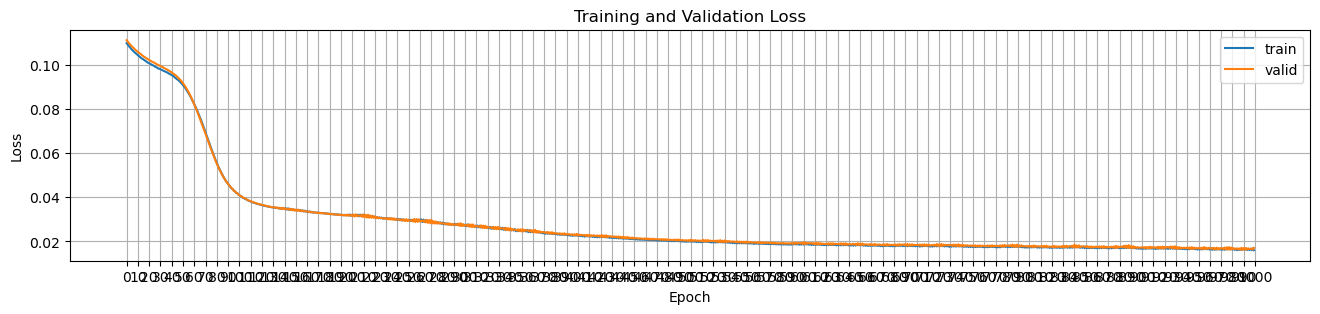

In [18]:
def plot_losses(train_losses, valid_losses):

    fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    ax.plot(train_losses, label="train")
    ax.plot(valid_losses, label="valid")
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_xticks(np.arange(0, len(train_losses)+1, 10))
    ax.set_xticklabels(np.arange(0, len(train_losses)+1, 10))
    ax.set_ylabel("Loss")
    ax.set_title("Training and Validation Loss")
    ax.grid()
    plt.show()
    
plot_losses(train_losses, valid_losses)

In [19]:
y_pred = model(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

Loss finale = 1.6221e-02


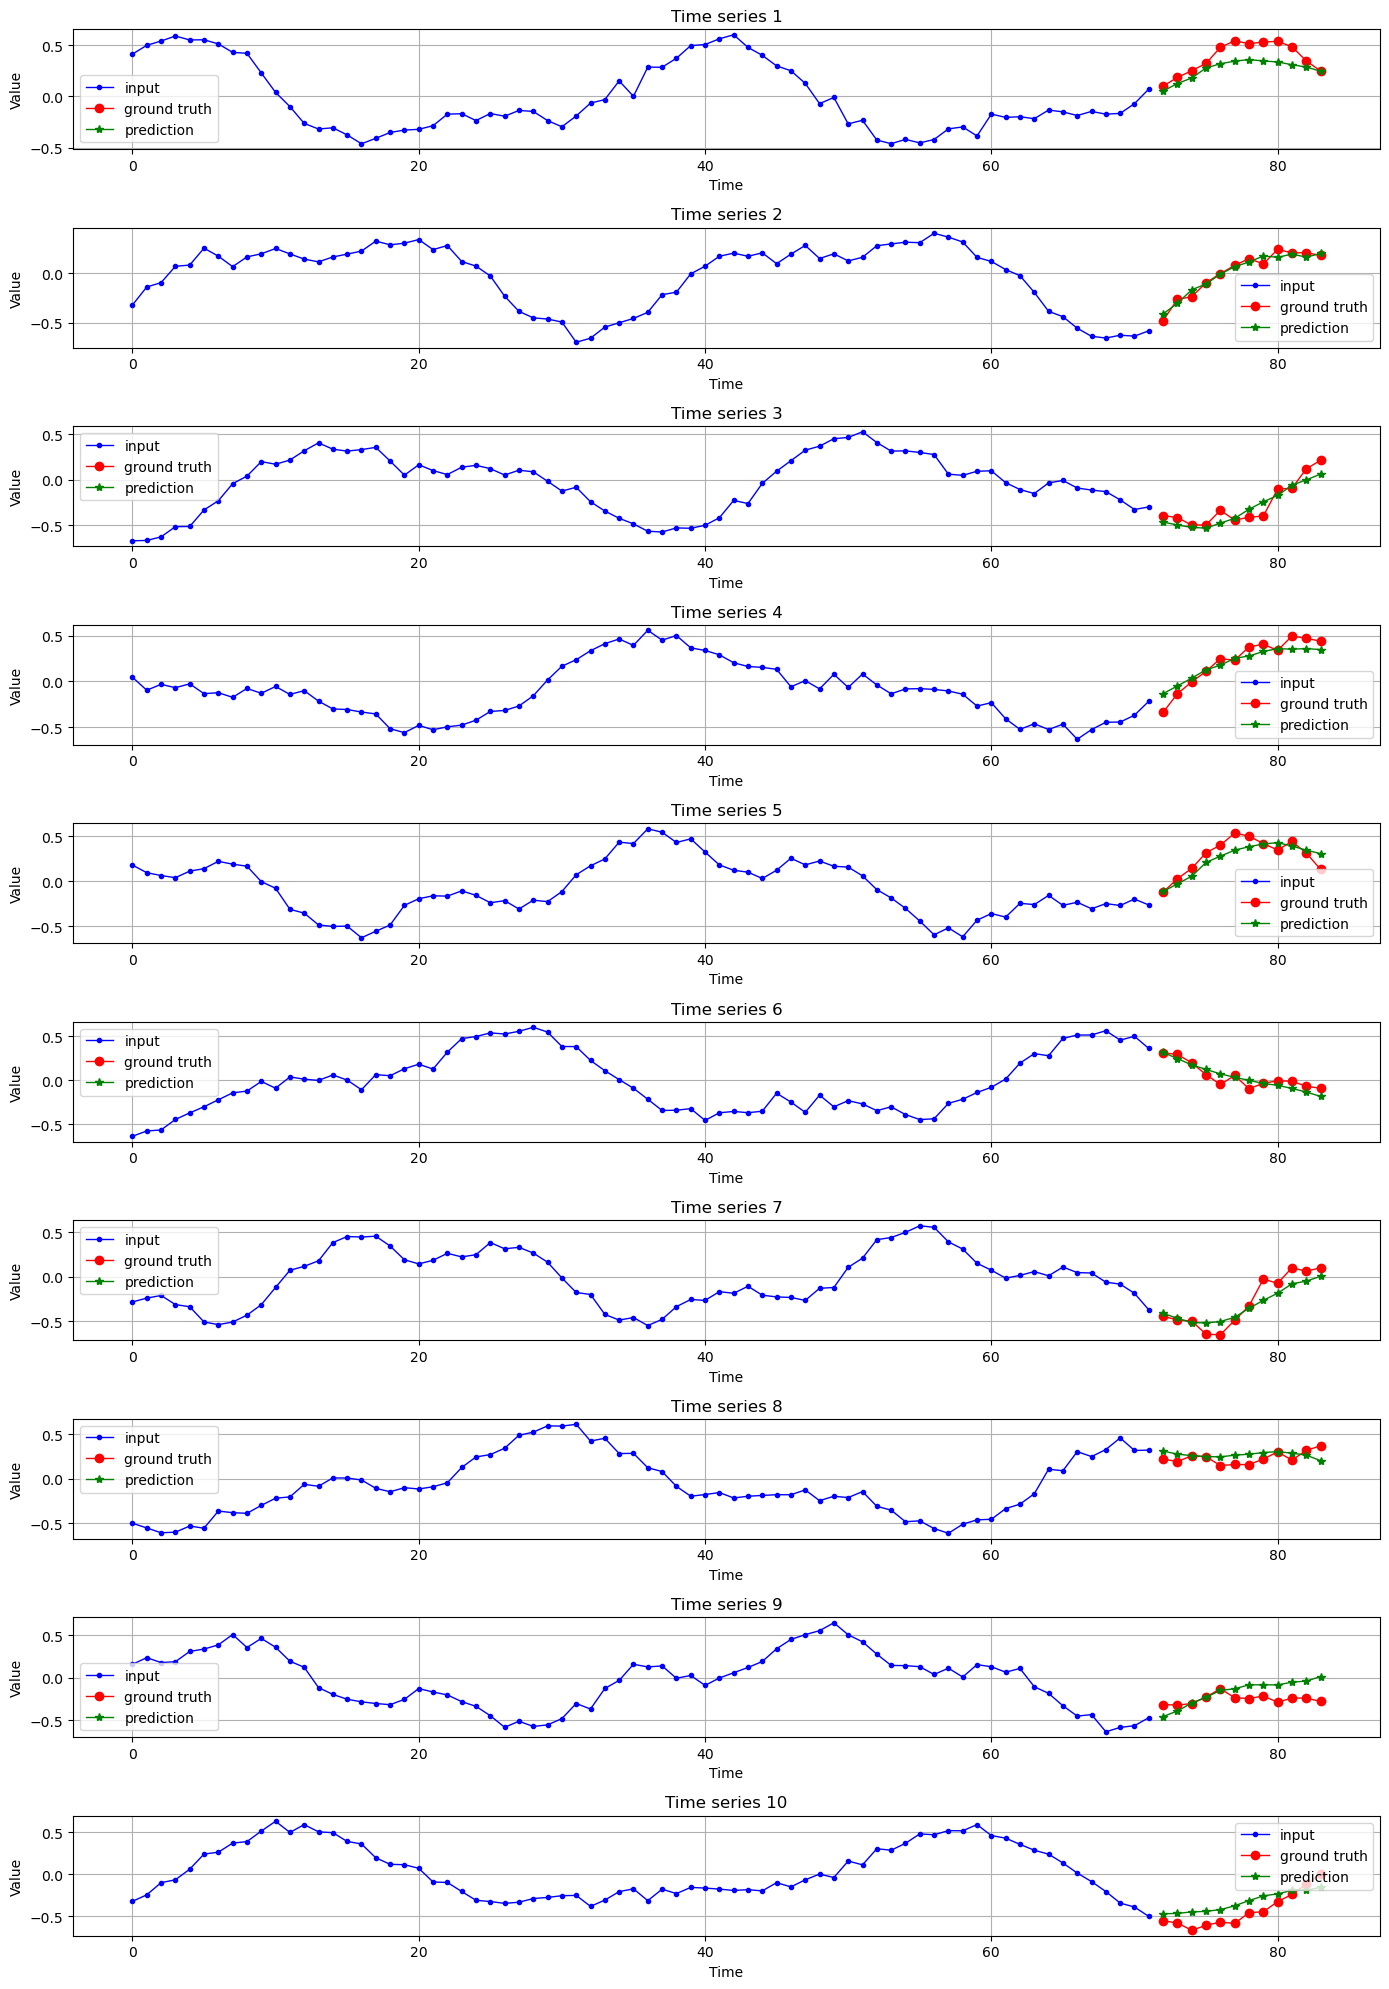

In [20]:
def plot_samples(X_valid, y_valid, model, n_ahead=n_ahead, device=device, N=10):

    fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
    x_shift = X_valid.shape[-1]

    for i in range(N):
        input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
        target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
        output = model(input)
        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        
        ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
        ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
        ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
        ax[i].set_title(f"Time series {i+1}")
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Value")
        ax[i].legend()
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()
    
plot_samples(X_valid, y_valid, model, n_ahead=n_ahead, device=device, N=10)

# Toy 2 : LSTM

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=7, dropout=0.2, batch_first=True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs):
        """Forward pass through the network.
            x has shape (batch_size, seq_length, input_size)
        """
        h0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        
        x, _ = self.lstm(inputs, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        x = self.dropout(x[:,-1,:])  # Apply dropout to the last time step's output
        x = self.fc(x)  # out shape: (batch_size, output_size)
        
        return x
    
    def __repr__(self):
        return f"LSTMModel(input_size={self.lstm.input_size}, hidden_size={self.hidden_size}, num_layers={self.num_layers}, output_size={self.fc.out_features}, dropout={self.dropout.p})"

In [22]:
lstm = LSTMModel(
    input_size=1,
    hidden_size=hidden_dim,
    num_layers=num_layers,
    output_size=n_ahead,
    dropout=0.2
).to(device)

print(lstm)

LSTMModel(input_size=1, hidden_size=64, num_layers=4, output_size=12, dropout=0.2)


In [23]:
criterion = nn.MSELoss()
# lr = 1e-4
# num_epochs = 1000
# patience = 30
# min_delta = 1e-3

early_stopping = EarlyStoppingCallback(patience=patience, min_delta=min_delta)

In [24]:
model = lstm 
PATH_TO_SAVE = 'best_lstm_model.pth'
print(f"Start training RNN model for {num_epochs} epochs")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training RNN model for 1000 epochs


In [25]:
model = lstm
PATH_TO_SAVE = 'best_lstm_model.pth'
print(f"Start training LSTM model for {num_epochs} epochs")

train_losses, valid_losses, trained_model = train_loop(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    early_stopping=early_stopping,
    PATH_TO_SAVE=PATH_TO_SAVE,
    display_frequency=1
)

Start training LSTM model for 1000 epochs
epoch    1/1000, training loss = 1.1051e-01, validation loss = 1.1211e-01 - Saving model at epoch 1 with validation loss 1.1211e-01
epoch    2/1000, training loss = 1.1034e-01, validation loss = 1.1196e-01 - Saving model at epoch 2 with validation loss 1.1196e-01
epoch    3/1000, training loss = 1.1024e-01, validation loss = 1.1179e-01 - Saving model at epoch 3 with validation loss 1.1179e-01
epoch    4/1000, training loss = 1.1010e-01, validation loss = 1.1158e-01 - Saving model at epoch 4 with validation loss 1.1158e-01
epoch    5/1000, training loss = 1.0998e-01, validation loss = 1.1143e-01 - Saving model at epoch 5 with validation loss 1.1143e-01
epoch    6/1000, training loss = 1.0972e-01, validation loss = 1.1129e-01 - Saving model at epoch 6 with validation loss 1.1129e-01
epoch    7/1000, training loss = 1.0959e-01, validation loss = 1.1108e-01 - Saving model at epoch 7 with validation loss 1.1108e-01
epoch    8/1000, training loss = 1

In [26]:
model = lstm
model.load_state_dict(torch.load(PATH_TO_SAVE))

<All keys matched successfully>

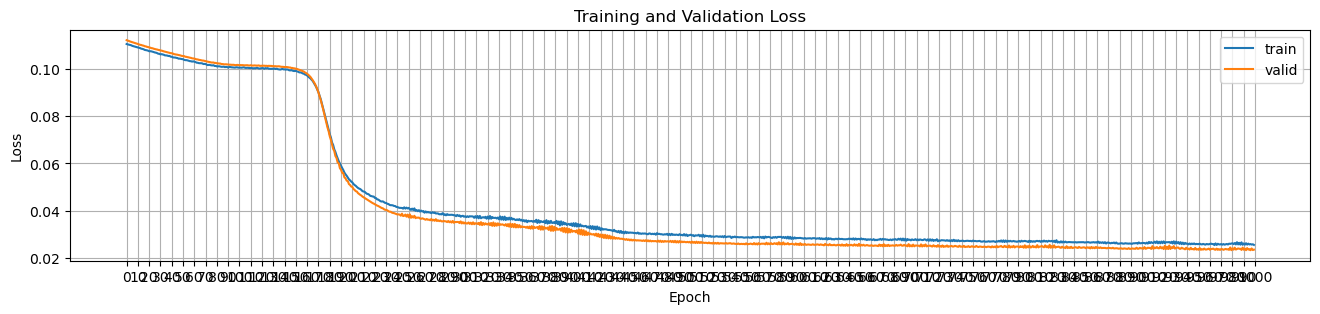

In [27]:
plot_losses(train_losses, valid_losses)

In [28]:
y_pred = model(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device) #.unsqueeze(-1)

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

Loss finale = 2.3305e-02


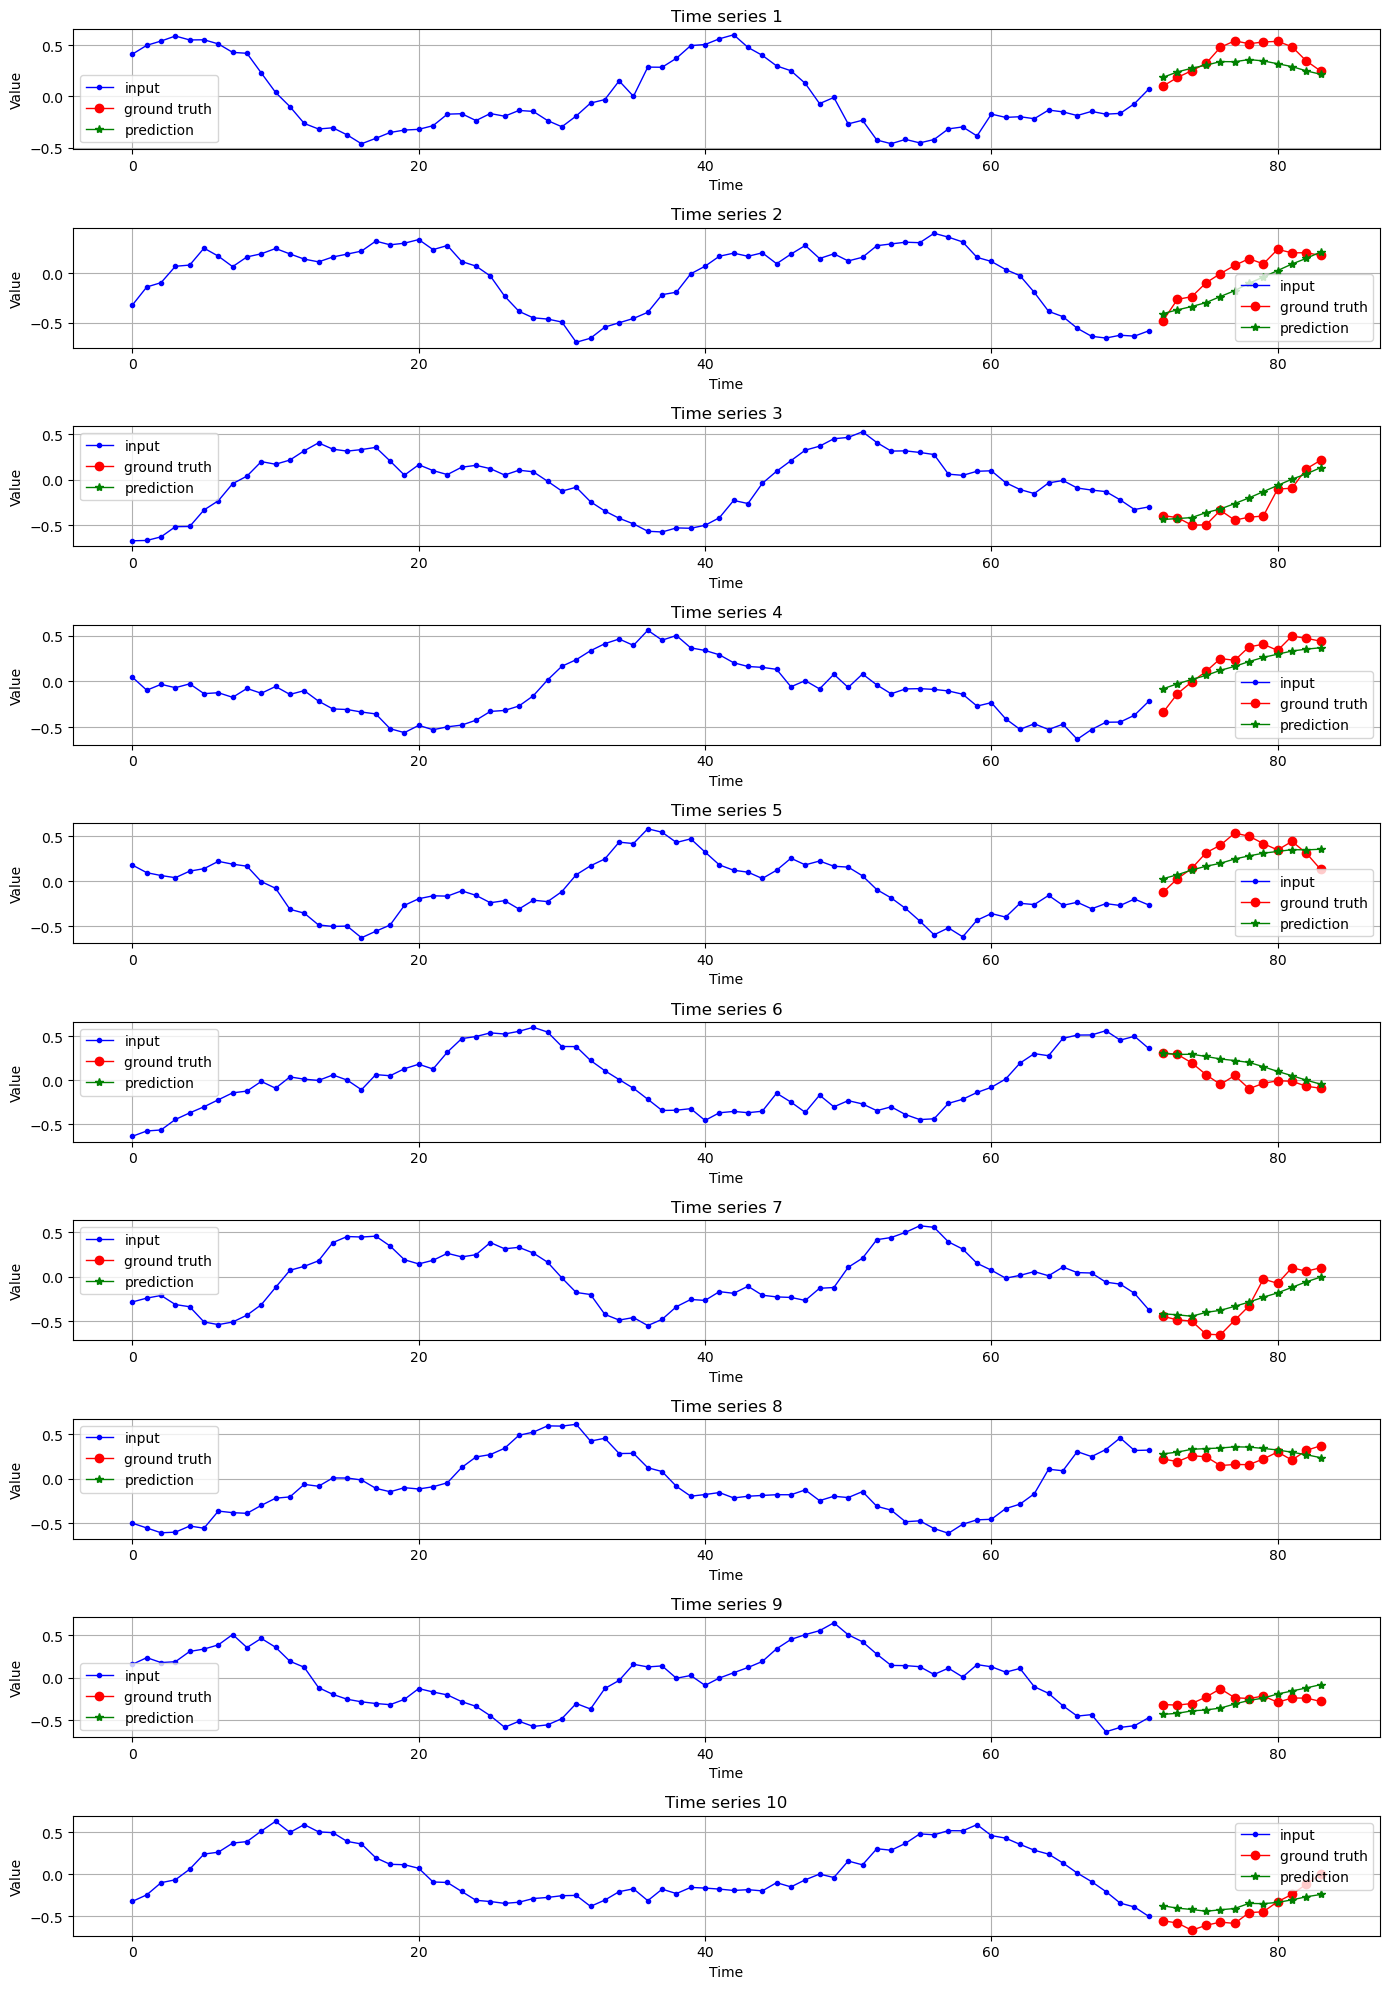

In [29]:
plot_samples(X_valid, y_valid, model, n_ahead=n_ahead, device=device, N=10)